In [34]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [46]:
data = pd.read_csv("hotel_bookings.csv")
df = data.head(5000).copy()

In [73]:
df = df.dropna(subset=['adr'])


# Для категориальных признаков заполним 'Unknown'
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('Unknown')
features = [
    'hotel', 'lead_time', 'arrival_date_month',
    'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies',
    'is_repeated_guest', 'previous_cancellations',
    'previous_bookings_not_canceled', 'required_car_parking_spaces',
    'total_of_special_requests', 'deposit_type', 'market_segment'
]

df = df[features + ['adr']].copy()

categorical = ['hotel', 'arrival_date_month', 'deposit_type', 'market_segment']
le = LabelEncoder()
for col in categorical:
    df[col] = le.fit_transform(df[col])

num_cols = df.select_dtypes(include=['float64','int64']).columns
df[num_cols] = df[num_cols].fillna(0)
print(df.isna().sum())
print("\nТипы столбцов после преобразования:")
print(df.dtypes)


hotel                             0
lead_time                         0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
required_car_parking_spaces       0
total_of_special_requests         0
deposit_type                      0
market_segment                    0
adr                               0
dtype: int64

Типы столбцов после преобразования:
hotel                               int64
lead_time                           int64
arrival_date_month                  int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
is_repeated_guest                   in

In [74]:

X = df[features]
y = df['adr']

# Полиномиальные признаки
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# 
X_train_lin, X_test_lin, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
X_train_svm, X_test_svm, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_svm_scaled = scaler.fit_transform(X_train_svm)
X_test_svm_scaled = scaler.transform(X_test_svm)



### МНК

In [75]:
lin_model = LinearRegression()
lin_model.fit(X_train_lin, y_train)
y_pred_lin = lin_model.predict(X_test_lin)

### SVM

In [76]:
svm_model = SVR(kernel='linear', C=100, gamma=0.1, epsilon=0.1)
svm_model.fit(X_train_svm_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_svm_scaled)


In [77]:
def mase(y_true, y_pred):
    naive_forecast = np.roll(y_true, 1)[1:]
    return np.mean(np.abs(y_true[1:] - y_pred[1:])) / np.mean(np.abs(y_true[1:] - naive_forecast))

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase_val = mase(y_true.values, y_pred)
    return mae, rmse, mape, mase_val

mae_lin, rmse_lin, mape_lin, mase_lin = metrics(y_test, y_pred_lin)
mae_svm, rmse_svm, mape_svm, mase_svm = metrics(y_test, y_pred_svm)

results = pd.DataFrame({
    'Model': ['Linear Regression (OLS)', 'Support Vector Regression (SVM)'],
    'MAE': [mae_lin, mae_svm],
    'RMSE': [rmse_lin, rmse_svm],
    'MAPE (%)': [mape_lin, mape_svm],
    'MASE': [mase_lin, mase_svm]
})
print(results.round(2))

                             Model    MAE   RMSE  MAPE (%)  MASE
0          Linear Regression (OLS)  33.00  51.15       inf  0.61
1  Support Vector Regression (SVM)  36.86  61.80       inf  0.68


### Визуализация

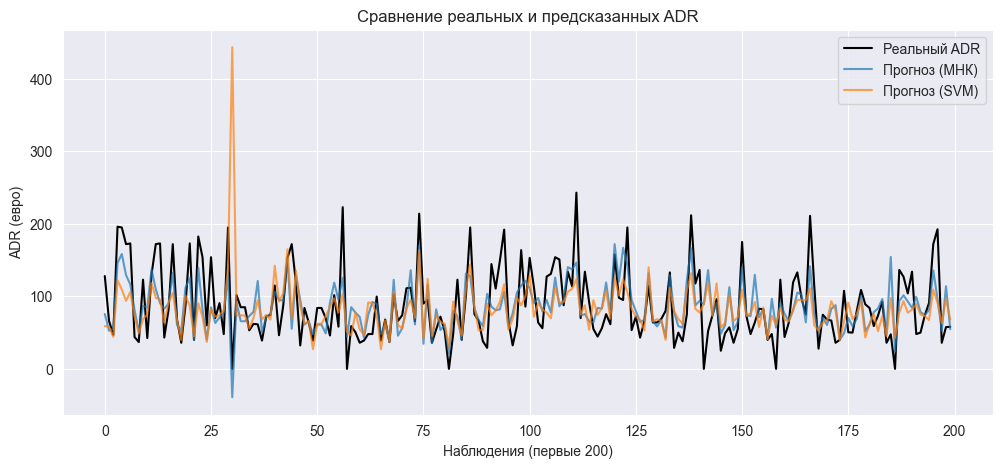

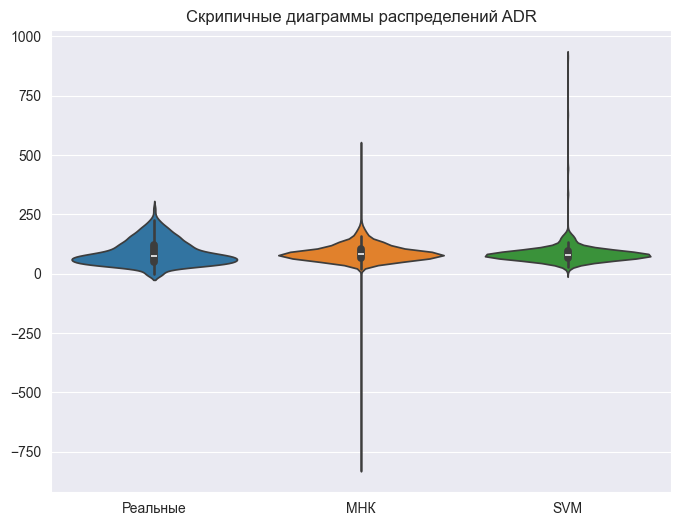

In [53]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label='Реальный ADR', color='black')
plt.plot(y_pred_lin[:200], label='Прогноз (МНК)', alpha=0.7)
plt.plot(y_pred_svm[:200], label='Прогноз (SVM)', alpha=0.7)
plt.title("Сравнение реальных и предсказанных ADR")
plt.xlabel("Наблюдения (первые 200)")
plt.ylabel("ADR (евро)")
plt.legend()
plt.show()

# Скрипичные диаграммы
plt.figure(figsize=(8,6))
sns.violinplot(data=pd.DataFrame({
    'Реальные': y_test,
    'МНК': y_pred_lin,
    'SVM': y_pred_svm
}))
plt.title("Скрипичные диаграммы распределений ADR")
plt.show()

### Перевод в задачу классификации

In [62]:
threshold = 100 
df['adr_class'] = (df['adr'] >= threshold).astype(int)

print(df[['adr', 'adr_class']].head(20))

       adr  adr_class
0     0.00          0
1     0.00          0
2    75.00          0
3    75.00          0
4    98.00          0
5    98.00          0
6   107.00          1
7   103.00          1
8    82.00          0
9   105.50          1
10  123.00          1
11  145.00          1
12   97.00          0
13  154.77          1
14   94.71          0
15   97.00          0
16   97.50          0
17   88.20          0
18  107.42          1
19  153.00          1


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[features]  
y = df['adr_class'] 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [64]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Обучение kNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:,1]  # вероятности для ROC и LogLoss

In [65]:
from sklearn.svm import SVC

# SVM 
svm_clf = SVC(kernel='rbf', C=1, gamma=0.01, probability=True)
svm_clf.fit(X_train_scaled, y_train)


y_pred_svm = svm_clf.predict(X_test_scaled)
y_prob_svm = svm_clf.predict_proba(X_test_scaled)[:,1]

In [66]:

def evaluate(y_true, y_pred, y_prob, model_name):
    from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_auc_score
    print(f"--- {model_name} ---")
    print(model_name, "Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print(model_name, "F1 Score:", round(f1_score(y_true, y_pred), 3))
    print(model_name, "LogLoss:", round(log_loss(y_true, y_prob), 3))
    print(model_name, "ROC AUC:", round(roc_auc_score(y_true, y_prob), 3))
    print(model_name, "Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\n")


--- kNN ---
kNN Accuracy: 0.799
kNN F1 Score: 0.716
kNN LogLoss: 1.356
kNN ROC AUC: 0.873
kNN Confusion Matrix:
 [[546 112]
 [ 89 253]]


--- SVM ---
SVM Accuracy: 0.756
SVM F1 Score: 0.561
SVM LogLoss: 0.491
SVM ROC AUC: 0.817
SVM Confusion Matrix:
 [[600  58]
 [186 156]]




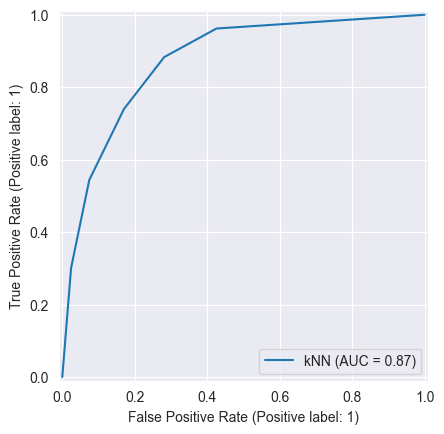

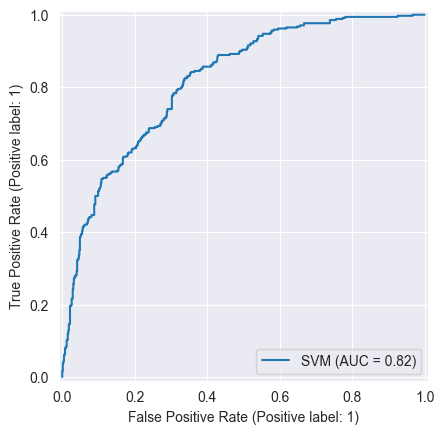

In [67]:
from sklearn.metrics import RocCurveDisplay

# kNN
evaluate(y_test, y_pred_knn, y_prob_knn, model_name="kNN")

# SVM
evaluate(y_test, y_pred_svm, y_prob_svm, model_name="SVM")

# ROC 
RocCurveDisplay.from_predictions(y_test, y_prob_knn, name='kNN')
RocCurveDisplay.from_predictions(y_test, y_prob_svm, name='SVM')
plt.show()


In [68]:
class_counts = df['adr_class'].value_counts()
print(class_counts)

class_ratios = df['adr_class'].value_counts(normalize=True)
print(class_ratios)

adr_class
0    3381
1    1619
Name: count, dtype: int64
adr_class
0    0.6762
1    0.3238
Name: proportion, dtype: float64


In [69]:
# Разделяем по классам
class_0 = df[df['adr_class'] == 0]
class_1 = df[df['adr_class'] == 1]

# Берём столько же объектов из класса 0, сколько в классе 1
class_0_downsampled = class_0.sample(len(class_1), random_state=123)

df_balanced = pd.concat([class_0_downsampled, class_1])
print(df_balanced['adr_class'].value_counts())


adr_class
0    1619
1    1619
Name: count, dtype: int64


--- kNN ---
kNN Accuracy: 0.778
kNN F1 Score: 0.791
kNN LogLoss: 1.78
kNN ROC AUC: 0.853
kNN Confusion Matrix:
 [[232  92]
 [ 52 272]]


--- SVM ---
SVM Accuracy: 0.718
SVM F1 Score: 0.715
SVM LogLoss: 0.543
SVM ROC AUC: 0.796
SVM Confusion Matrix:
 [[236  88]
 [ 95 229]]




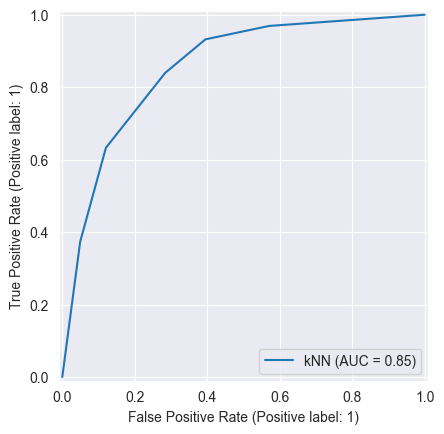

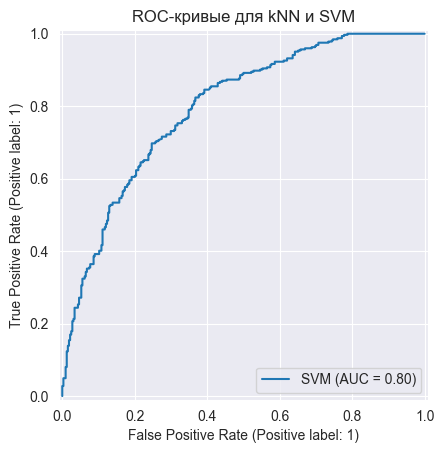

In [70]:
X_bal = df_balanced[features]
y_bal = df_balanced['adr_class']

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:,1]

svm_clf = SVC(kernel='rbf', C=1, gamma=0.01, probability=True)
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_test_scaled)
y_prob_svm = svm_clf.predict_proba(X_test_scaled)[:,1]



evaluate(y_test, y_pred_knn, y_prob_knn, "kNN")
evaluate(y_test, y_pred_svm, y_prob_svm, "SVM")

RocCurveDisplay.from_predictions(y_test, y_prob_knn, name='kNN')
RocCurveDisplay.from_predictions(y_test, y_prob_svm, name='SVM')
plt.title("ROC-кривые для kNN и SVM")
plt.show()

In [71]:
X_all = df[features]       # все признаки без балансировки
y_all = df['adr_class']
X_all_scaled = scaler.transform(X_all)
y_pred_knn_all = knn.predict(X_all_scaled)
y_prob_knn_all = knn.predict_proba(X_all_scaled)[:,1]

# SVM
y_pred_svm_all = svm_clf.predict(X_all_scaled)
y_prob_svm_all = svm_clf.predict_proba(X_all_scaled)[:,1]


evaluate(y_all, y_pred_knn_all, y_prob_knn_all, "kNN")
evaluate(y_all, y_pred_svm_all, y_prob_svm_all, "SVM")

--- kNN ---
kNN Accuracy: 0.794
kNN F1 Score: 0.738
kNN LogLoss: 1.181
kNN ROC AUC: 0.902
kNN Confusion Matrix:
 [[2520  861]
 [ 168 1451]]


--- SVM ---
SVM Accuracy: 0.74
SVM F1 Score: 0.647
SVM LogLoss: 0.522
SVM ROC AUC: 0.817
SVM Confusion Matrix:
 [[2508  873]
 [ 427 1192]]


